## Libraries

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('french'))
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import pandas as pd
import io
import string
import numpy as np
import re
from google.colab import files


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from gensim import corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary

from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns

## Initial Dataset visualisation

In [3]:
uploaded = files.upload()

Saving LadyAgri Database_Raw - CIV.xlsx to LadyAgri Database_Raw - CIV.xlsx


In [4]:
df_ladyAgri = pd.read_excel('LadyAgri Database_Raw - CIV.xlsx', header=None)
df_ladyAgri.head()

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,F2,F3,F4,F5,F6,F6_1_TEXT,F7,F7_1_TEXT,F8,F8_1_TEXT
1,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,What is the percentage of women in supervisory...,What is the percentage of women employees/memb...,Do your employees receive health benefits and ...,What is the percentage of women suppliers?,Does the business specifically target/benefit ...,Does the business specifically target/benefit ...,Does the business have a positive impact on th...,Does the business have a positive impact on th...,Is your production model sustainable ? Explain...,Is your production model sustainable ? Explain...
2,2022-01-11 03:10:29,2022-01-11 03:24:05,IP Address,NaN,100,815,True,2022-01-11 03:24:05.468000,R_1IL8qtNWhdv2yGf,NaN,...,51-60%,51-60%,No,NaN,"Yes, explain",Ce sont les femmes qui en majorité font la tra...,NaN,NaN,NaN,NaN
3,2022-01-11 02:23:56,2022-01-11 03:34:51,IP Address,NaN,100,4255,True,2022-01-11 03:34:52.094000,R_2CHdOa6xzHbKAIJ,NaN,...,10-20%,10-20%,No,10-20%,"Yes, explain",Le commerce de l'attiéké et du placali est fai...,"Yes, explain",Notre activité comble le manque de produits su...,"Yes, explain",Nous avons 10 hectares de terres pour produire...
4,2022-01-11 05:47:17,2022-01-11 06:02:18,IP Address,NaN,100,901,True,2022-01-11 06:02:19.099000,R_2YYcsoxWKmBVxLC,NaN,...,71-80%,51-60%,Yes,31-40%,No,NaN,"Yes, explain","Elle achète au prix juste , accompagne certain...","Yes, explain",Nous reutilisons les déchets issus de notre ac...


In [5]:
df = df_ladyAgri
df.columns = df_ladyAgri.iloc[0]

df = df[2:].reset_index(drop=True)

columns_to_drop = list(range(0, 20)) + list(range(23, 25))

df = df.drop(df.columns[columns_to_drop], axis=1)


df.head()

,A4,A5,A6,A9,A9_2_TEXT,B1,B2,B3,B4,B5,...,F2,F3,F4,F5,F6,F6_1_TEXT,F7,F7_1_TEXT,F8,F8_1_TEXT
0,Single,University,1984,Côte d'Ivoire,NaN,NaN,Other,NaN,NaN,Je suis producteur,...,51-60%,51-60%,No,NaN,"Yes, explain",Ce sont les femmes qui en majorité font la tra...,NaN,NaN,NaN,NaN
1,Married,Professional training,29/12/1970,"Other, specify",France,NaN,Family-Led SME,NaN,8,0,...,10-20%,10-20%,No,10-20%,"Yes, explain",Le commerce de l'attiéké et du placali est fai...,"Yes, explain",Notre activité comble le manque de produits su...,"Yes, explain",Nous avons 10 hectares de terres pour produire...
2,Single,University,1978,Côte d'Ivoire,NaN,NaN,Other,NaN,NaN,1,...,71-80%,51-60%,Yes,31-40%,No,NaN,"Yes, explain","Elle achète au prix juste , accompagne certain...","Yes, explain",Nous reutilisons les déchets issus de notre ac...
3,Married,University,1991,Côte d'Ivoire,NaN,NaN,Women’s association,28,NaN,28,...,More than 90%,Less than 10%,No,More than 90%,"Yes, explain",Les femmes unissent leur force pour l'avanceme...,"Yes, explain",Elle accorde de l'attiéké à la cantine scolaire,"Yes, explain",L'entreprise compte diversifier ses marchés
4,Single,University,17/12/1982,Côte d'Ivoire,NaN,NaN,Women-Led SME,NaN,06,05,...,71-80%,71-80%,No,51-60%,"Yes, explain",1/ le manioc est vendu à des femmes productric...,"Yes, explain",Création d'emplois et de richesse,"Yes, explain",Nous produisons du manioc chaque année sur des...


In [6]:
df.dtypes

0
A4           object
A5           object
A6           object
A9           object
A9_2_TEXT    object
              ...  
F6_1_TEXT    object
F7           object
F7_1_TEXT    object
F8           object
F8_1_TEXT    object
Length: 92, dtype: object

## Cleaning Data

In [7]:
categorical = ['A3', 'A4', 'A5', 'A9', 'A9_2_TEXT', 'B1', 'B2', 'B6', 'B7', 'B9', 'B9_9_TEXT', 'B10', 'B11',
               'B12', 'B13', 'B14', 'B14_2_TEXT', 'B15', 'B15_1_TEXT', 'B17', 'B18', 'C4', 'D2', 'D3', 'D4',
               'D5', 'D6', 'D7', 'D8', 'D12', 'D13', 'D14_NPS_GROUP', 'D14','E1', 'E2', 'E3', 'E3_6_TEXT',
               'E4_NPS_GROUP', 'E4', 'E6', 'E6_1_TEXT', 'E7', 'E8', 'E9', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6',
               'F7', 'F8', 'D13_25_TEXT', 'D10']
numerical = ['A6', 'B3', 'B4', 'B5', 'D9', 'B6_8_TEXT', 'B13_1_TEXT', 'B13_2_TEXT', 'B13_3_TEXT', 'B13_4_TEXT', 'B13_5_TEXT', 'B13_6_TEXT', 'B13_7_TEXT', 'D3_1_TEXT',
             'D3_2_TEXT', 'D3_3_TEXT', 'D3_4_TEXT', 'D3_5_TEXT', 'D3_6_TEXT', 'D3_7_TEXT', 'D11_1_TEXT', 'D11_2_TEXT', 'D11_3_TEXT']
potential_textbased = ['B8', 'B11_1_TEXT', 'B16', 'B17_1_TEXT', 'C1', 'C2', 'C3', 'C5', 'C6', 'D1', 'D15', 'E5',
                       'F6_1_TEXT', 'F7_1_TEXT']
cols_with_issues = ['D11']

## B3 & B4

In [8]:
df['B3_B4_Combined'] = df['B3_B4_Combined'] = (df['B3'].fillna('') + df['B4'].fillna('')).str.extract('(\d+)', expand=False).astype(float)
df = df.drop(columns = ['B3', 'B4'])
df['B3_B4_Combined']

0       NaN
1       8.0
2       NaN
3      28.0
4       6.0
       ... 
387     NaN
388     NaN
389     NaN
390     NaN
391     NaN
Name: B3_B4_Combined, Length: 392, dtype: float64

In [9]:
df['B3_B4_Combined'][21]

8.0

## B5

In [10]:
df['B5'] = df['B5'].str.replace(r'[^1-9]', '', regex=True)
df['B5'] = pd.to_numeric(df['B5'], errors='coerce')
df['B5']

0       NaN
1       NaN
2       1.0
3      28.0
4       5.0
       ... 
387     NaN
388     NaN
389     NaN
390     NaN
391     NaN
Name: B5, Length: 392, dtype: float64

## B7

In [11]:
data = df['B7'].unique().tolist()
data = ['' if isinstance(val, float) and np.isnan(val) else val for val in data]

unique_values = set()
for row in data:
    values = [v.strip() for v in row.split(',')]
    unique_values.update(values)

print("Unique values:")
for val in unique_values:
    print(val)

Unique values:

Production
Distribution
Agri-Services - Inputs supply
Processing
Logistics/ Transport
Aggregation (group buying for reselling)


In [12]:
categories = [
    'Distribution',
    'Logistics/ Transport',
    'Production',
    'Aggregation (group buying for reselling)',
    'Processing',
    'Agri-Services - Inputs supply'
]

df['B7'] = df['B7'].apply(lambda x: '' if isinstance(x, float) and np.isnan(x) else x)

for category in categories:
    df[category] = 0

for index, row in df.iterrows():
    if pd.notna(row['B7']):
        for category in categories:
            if category in row['B7']:
                df.at[index, category] = 1

df.drop('B7', axis=1, inplace=True)

df.head()

,A4,A5,A6,A9,A9_2_TEXT,B1,B2,B5,B6,B6_8_TEXT,...,F7_1_TEXT,F8,F8_1_TEXT,B3_B4_Combined,Distribution,Logistics/ Transport,Production,Aggregation (group buying for reselling),Processing,Agri-Services - Inputs supply
0,Single,University,1984,Côte d'Ivoire,NaN,NaN,Other,NaN,Between 6 months and a year,NaN,...,NaN,NaN,NaN,NaN,0,0,1,0,0,0
1,Married,Professional training,29/12/1970,"Other, specify",France,NaN,Family-Led SME,NaN,Between 6 months and a year,NaN,...,Notre activité comble le manque de produits su...,"Yes, explain",Nous avons 10 hectares de terres pour produire...,8.0,1,0,1,0,1,0
2,Single,University,1978,Côte d'Ivoire,NaN,NaN,Other,1.0,Less than 3 months,NaN,...,"Elle achète au prix juste , accompagne certain...","Yes, explain",Nous reutilisons les déchets issus de notre ac...,NaN,0,0,1,0,1,0
3,Married,University,1991,Côte d'Ivoire,NaN,NaN,Women’s association,28.0,"More than 3, specify",5 ans,...,Elle accorde de l'attiéké à la cantine scolaire,"Yes, explain",L'entreprise compte diversifier ses marchés,28.0,0,0,0,0,1,0
4,Single,University,17/12/1982,Côte d'Ivoire,NaN,NaN,Women-Led SME,5.0,Less than 3 months,NaN,...,Création d'emplois et de richesse,"Yes, explain",Nous produisons du manioc chaque année sur des...,6.0,1,0,0,0,0,0


## B13

In [13]:
df['B13_Combined'] = df[['B13_1_TEXT', 'B13_2_TEXT', 'B13_3_TEXT', 'B13_4_TEXT', 'B13_5_TEXT', 'B13_6_TEXT', 'B13_7_TEXT']].fillna('').sum(axis=1)

df['B13_Combined'] = df['B13_Combined'].str.replace('millions', '000000', case=False)
df['B13_Combined'] = df['B13_Combined'].str.replace(',', '.')

def clean_and_convert(value):
    cleaned_value = re.sub(r'[^0-9]', '', str(value))
    if cleaned_value:
        return float(cleaned_value)
    else:
        return None


df['B13_Combined'] = df['B13_Combined'].apply(clean_and_convert)

df['B13_Combined'] = df['B13_Combined'].apply(lambda x: x * 100000 if x < 10 else x)

df = df.drop(columns=['B13_1_TEXT', 'B13_2_TEXT', 'B13_3_TEXT', 'B13_4_TEXT', 'B13_5_TEXT', 'B13_6_TEXT', 'B13_7_TEXT'])
df['B13_Combined'][167]


800000.0

In [14]:
df['B13_Combined'].isna().sum()

208

## D3_1,2,3,4,5,6,7_TEXT

In [15]:
df['D3_Combined'] = df[['D3_1_TEXT', 'D3_2_TEXT', 'D3_3_TEXT', 'D3_4_TEXT', 'D3_5_TEXT', 'D3_6_TEXT', 'D3_7_TEXT']].fillna('').sum(axis=1)
df['D3_Combined'] = df['D3_Combined'].str.replace(r' millions', '000000', case=False)
df['D3_Combined'] = df['D3_Combined'].str.replace(r'[^0-9]', '')

df['D3_Combined'] = pd.to_numeric(df['D3_Combined'], errors='coerce')

df = df.drop(columns=['D3_1_TEXT', 'D3_2_TEXT', 'D3_3_TEXT', 'D3_4_TEXT', 'D3_5_TEXT', 'D3_6_TEXT', 'D3_7_TEXT'])
df['D3_Combined']

<ipython-input-15-338f74c39e5b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['D3_Combined'] = df['D3_Combined'].str.replace(r'[^0-9]', '')


0            NaN
1            NaN
2            NaN
3      5000000.0
4            NaN
         ...    
387          NaN
388          NaN
389          NaN
390          NaN
391          NaN
Name: D3_Combined, Length: 392, dtype: float64

## B1

In [16]:
df = df.drop(columns = ['B1'])

## B6_8_TEXT

In [17]:
def transform_value(value):
    if pd.notnull(value):
        value = ''.join(filter(str.isdigit, str(value)))
        if value and len(value) >= 4:
            try:
                value = str(datetime.now().year - int(value[-4:]))
            except ValueError:
                pass
    return value

df['B6_8_TEXT'] = df['B6_8_TEXT'].apply(transform_value)
df['B6_8_TEXT'] = pd.to_numeric(df['B6_8_TEXT'], errors='coerce')
df['B6_8_TEXT']

0      NaN
1      NaN
2      NaN
3      5.0
4      NaN
      ... 
387    NaN
388    NaN
389    NaN
390    NaN
391    NaN
Name: B6_8_TEXT, Length: 392, dtype: float64

## B9_TEXT & B11_1_TEXT

In [18]:
df['B11_1_TEXT'] = np.nan

## B14 & B14_2_TEXT

In [19]:
def replace_text(row):
    if row['B14'] is not None and row['B14'] != 'Other, specify':
        return row['B14']
    else:
        return row['B14_2_TEXT']

df['B14'] = df.apply(replace_text, axis=1)

# Optionally, drop the column 'B4' if you no longer need it
df = df.drop(columns=['B14_2_TEXT'])

print(df['B14'])


0      Cassava
1      Cassava
2      Cassava
3      Cassava
4      Cassava
        ...   
387        NaN
388        NaN
389        NaN
390        NaN
391        NaN
Name: B14, Length: 392, dtype: object


In [20]:
df['B14'][30]

'Cacao'

## B15_1_TEXT

In [21]:
def nltk_words(i):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    stop_words = set(stopwords.words('french'))
    common_verbs = ['a', '-', ',', 'être', 'avoir', 'faire', 'aller', 'pouvoir', 'vouloir', 'savoir', 'voir', 'venir', 'devoir', 'prendre', 'donner', 'trouver', 'dire', 'mettre', 'falloir', 'laisser', 'passer', 'aimer', 'comprendre', 'partir']

    for verb in common_verbs:
        stop_words.add(verb)

    lemmatizer = WordNetLemmatizer()

    def remove_stopwords_numbers_punct(text):
        if isinstance(text, str):
            # Remove punctuation
            text = re.sub(r'[^\w\s]', '', text)
            # Tokenize and lemmatize
            words = [lemmatizer.lemmatize(word) for word in word_tokenize(text.lower())]
            # Remove stopwords, numbers, single characters, and return the result
            return [word for word in words if word not in stop_words and not word.isnumeric() and len(word) >= 5]
        else:
            return []

    df['cleaned_text'] = df[i].apply(lambda x: remove_stopwords_numbers_punct(x) if pd.notnull(x) else [])

    # Step 2: Frequency Analysis
    all_words = [word for text in df['cleaned_text'] for word in text if len(word) >= 4]
    freq_dist = FreqDist(all_words)
    print(freq_dist.most_common(10))  # Print the 10 most common words

    # Step 3: TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    print(i)
    tfidf_matrix = tfidf_vectorizer.fit_transform([" ".join(text) for text in df['cleaned_text']])
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Step 4: Topic Modeling (LDA)
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(tfidf_matrix)

    # Step 5: Replace similar words
    def replace_similar_words(row):
      cleaned_text = row['cleaned_text']
      for i, word in enumerate(cleaned_text):
          # Check if the word is similar to any TF-IDF term
          similar_words = [term for term in feature_names if abs(cosine_similarity(tfidf_vectorizer.transform([word]), tfidf_vectorizer.transform([term]))[0][0]) > 0.5]
          if similar_words:
              cleaned_text[i] = similar_words[0]  # Replace with the most similar term
      return cleaned_text

    df['cleaned_text'] = df.apply(replace_similar_words, axis=1)
    df[i] = df['cleaned_text']
    df.drop(columns=['cleaned_text'])
    # Step 6: Visualization
    freq_dist.plot(50, cumulative=False)
    plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


[('banane', 33), ('piment', 25), ('culture', 21), ('aubergine', 17), ('gombo', 17), ('manioc', 15), ('tomate', 12), ('cacao', 11), ('produisons', 10), ('production', 9)]
B15_1_TEXT


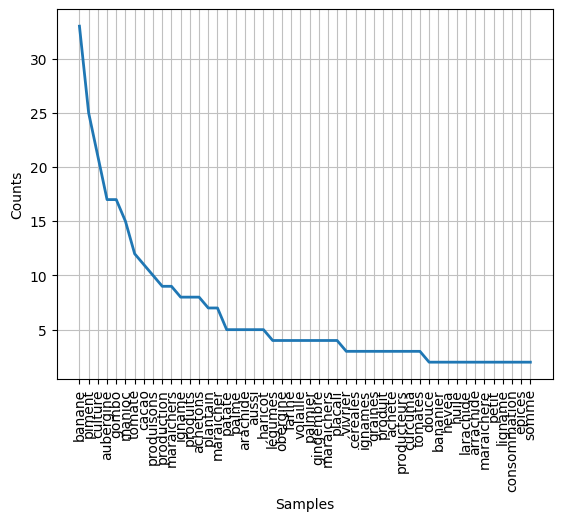

In [22]:
nltk_words('B15_1_TEXT')

In [23]:
df['B15_1_TEXT'] = df['B15_1_TEXT'].apply(lambda x: x[0] if len(x) >= 1 else None)
df['B15_1_TEXT']

0         None
1         None
2        cacao
3       manioc
4      vivrier
        ...   
387       None
388       None
389       None
390       None
391       None
Name: B15_1_TEXT, Length: 392, dtype: object

## B17_1_TEXT

In [24]:
# Assuming df is your DataFrame and the column is named 'column_name'
df['Temp'] = df['B17_1_TEXT'].apply(lambda x: 'SARL' if isinstance(x, str) and 'sarl' in x.lower() else x)
df['Temp'] = df['Temp'].apply(lambda x: 'Societe Cooperative' if isinstance(x, str) and 'coop' in x.lower() else x)
df['B17_1_TEXT'] = df['Temp']
df = df.drop(columns = ['Temp'])

In [25]:
df['B17_1_TEXT'].isna().sum()

152

## D1

In [26]:
df = df.drop(columns = ['D1'])

## D9, D10, D11, D11_1TEXT, D11_2_TEXT, D11_3_TEXT

In [27]:
def convert_values(val):
    if val is not None and val != '' and isinstance(val, str):
      if 'millions' in val and 'milles' in val:
            return int(val) * 1000000
      elif 'millions' in val:
            return int(''.join(filter(str.isdigit, val))) * 1000000
      elif 'milles' in val:
            return int(''.join(filter(str.isdigit, val))) * 1000
      else:
            # Assuming the non-matching values are integers
            return val
df['D9'] = df['D9'].apply(convert_values)

In [28]:
df['D9'][139]

2500000000

In [29]:
df['D11_1_TEXT'] = df['D11_1_TEXT'].str.replace(r'[^0-9]', '')
df['D11_1_TEXT'] = pd.to_numeric(df['D11_1_TEXT'], errors='coerce')

df['D11_1_TEXT'] = df['D11_1_TEXT'].astype('Int64')
df['D11_1_TEXT'][139]

<ipython-input-29-abbecb53ad98>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['D11_1_TEXT'] = df['D11_1_TEXT'].str.replace(r'[^0-9]', '')


18

## D13_25_TEXT

In [30]:
def replace_text(row):
    if row['D13'] is not None and row['D13'] != 'Other : specify':
        return row['D13']
    else:
        return row['D13_25_TEXT']

df['D13'] = df.apply(replace_text, axis=1)

# Optionally, drop the column 'B4' if you no longer need it
df = df.drop(columns=['D13_25_TEXT'])

print(df['D13'])


0      COOPEC 
1      Cofina 
2          SIB
3      COOPEC 
4       BICICI
        ...   
387        NaN
388        NaN
389        NaN
390        NaN
391        NaN
Name: D13, Length: 392, dtype: object


## E6

In [31]:
def replace_text(row):
    if row['E6'] is not None and row['E6'] != 'Yes, specify':
        return row['E6']
    else:
        return row['E6_1_TEXT']

df['E6'] = df.apply(replace_text, axis=1)

# Optionally, drop the column 'B4' if you no longer need it
df = df.drop(columns=['E6_1_TEXT'])

print(df['E6'])


0       No
1      NaN
2       No
3       No
4      NaN
      ... 
387    NaN
388    NaN
389    NaN
390    NaN
391    NaN
Name: E6, Length: 392, dtype: object


## B16

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('présidente', 83), ('directrice', 48), ('président', 33), ('directeur', 29), ('responsable', 27), ('lassociation', 20), ('presidente', 18), ('gestion', 15), ('comité', 13), ('coopérative', 12)]
B16


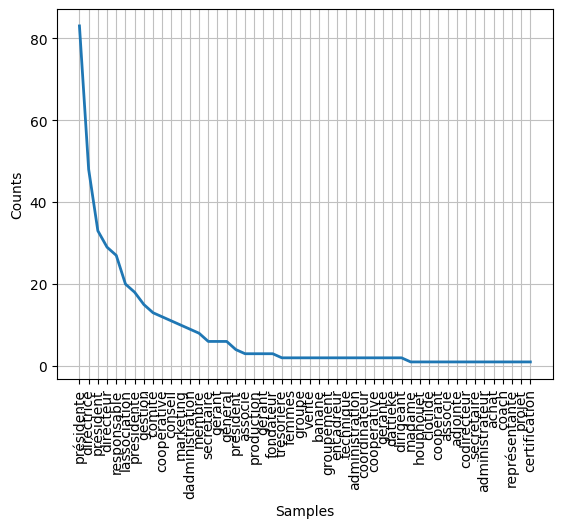

In [32]:
nltk_words(i = 'B16')

In [33]:
df['B16'] = df['B16'].apply(lambda x: x[0] if len(x) >= 1 else None)
df['B16']

0           membre
1      responsable
2      responsable
3       directrice
4        coopérant
          ...     
387           None
388           None
389           None
390           None
391           None
Name: B16, Length: 392, dtype: object

## D3

In [34]:
df = df.drop(columns = ['F6_1_TEXT'])

In [35]:
df = df.drop(columns = ['cleaned_text'])

In [36]:
df.to_csv('LadyAgri_Dataset.csv')